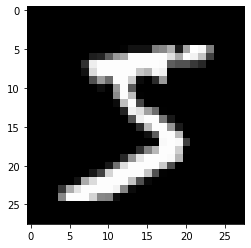

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import edf
import mnist_loader

train_images, train_labels = mnist_loader.load_mnist(section = 'training', path = 'MNIST')
test_images, test_labels = mnist_loader.load_mnist(section = 'testing', path = 'MNIST')

plt.imshow(train_images[0], cmap='gray', interpolation = 'nearest')
plt.show()

In [19]:
"""we will reshape the 28x28 grayscale images as 
784-dimensional vectors, which will be the network's inputs"""

train_images = train_images.reshape(len(train_images), -1)
test_images = test_images.reshape(len(test_images), -1)

In [20]:
"""we manually set the number of input features (784)
and number of classes (10) which will be used to
define the model"""

nInputs = 784
nLabels = 10

"""below, MLPparams is an EDF ParameterPackage whose
purpose is to define and store the parameters of the model,
while MLPgraph is a function that implements the model's
forward pass -- in this case, just a 1-hidden layer MLP"""

class MLPparams(edf.ParameterPackage):
    def __init__(self,nInputs, nHiddens, nLabels):
        self.first = edf.AffineParams(nInputs,nHiddens)
        self.last = edf.AffineParams(nHiddens,nLabels)
        
def MLPsigmoidgraph(Phi, x):
    h = edf.Sigmoid(edf.Affine(Phi.first, x))
    return edf.Softmax(edf.Affine(Phi.last, h))

"""we then construct a MLP with 64 hidden units"""

np.random.seed(1234)
edf.clear_compgraph()
xnode = edf.Input()
ynode = edf.Input()
nHiddens = 64
Phi = MLPparams(nInputs, nHiddens, nLabels)
probnode = MLPsigmoidgraph(Phi, xnode)
lossnode = edf.LogLoss(probnode, ynode)

In [21]:
"""the following functions are used to train the network.
training is done by iterating over mini-batches of size 'batch_size'
and updating the model's parameters with SGD"""

def run_epoch(batch_size, data, labels, xnode, ynode, probnode, lossnode=None):
    num_samples = len(data)
    total_err = 0.0
    num_batches = num_samples//batch_size
    for i in range(num_batches):
        start, end = i*batch_size, (i+1)*batch_size
        xnode.value = train_images[start:end]
        ynode.value = train_labels[start:end]
        edf.Forward()
        total_err += np.sum(np.not_equal(np.argmax(probnode.value, axis=1), ynode.value))
        if lossnode:
            edf.Backward(lossnode)
            edf.SGD()
        if i>0 and i%400 == 0:
            print ("\t Batch {}/{}".format(i, num_batches))
    return 100*total_err/num_samples

def train(num_epochs, batch_size, xnode, ynode, probnode, lossnode):
    train_err_log = []
    test_err_log = []
    for epoch in range(num_epochs):
        print("Epoch: {}/{}".format(epoch+1, num_epochs))
        train_err = run_epoch(batch_size, train_images, train_labels, xnode, ynode, probnode, lossnode)
        train_err_log.append(train_err)
        print ("\t Training Error {:.2f} %".format(train_err))
        test_err = run_epoch(len(test_images), test_images, test_labels, xnode, ynode, probnode)
        test_err_log.append(test_err)
        print ("\t Test Error {:.2f} %".format(test_err))
    return train_err_log, test_err_log

In [22]:
"""now, we are ready to train the network. we can choose SGD's learning rate
by changing edf.learning_rate, which we will set as 0.5 for now."""

num_epochs = 10
batch_size = 64
edf.learning_rate = 0.5
train_err_log, test_err_log = train(num_epochs, batch_size, xnode, ynode, probnode, lossnode)

Epoch: 1/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 11.51 %
	 Test Error 7.89 %
Epoch: 2/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 6.37 %
	 Test Error 5.77 %
Epoch: 3/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 5.00 %
	 Test Error 4.56 %
Epoch: 4/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 4.10 %
	 Test Error 3.78 %
Epoch: 5/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 3.49 %
	 Test Error 3.25 %
Epoch: 6/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 3.09 %
	 Test Error 2.85 %
Epoch: 7/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 2.78 %
	 Test Error 2.60 %
Epoch: 8/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 2.49 %
	 Test Error 2.35 %
Epoch: 9/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 2.24 %
	 Test Error 2.20 %
Epoch: 10/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 2.01 %
	 Test Error 2.06 %


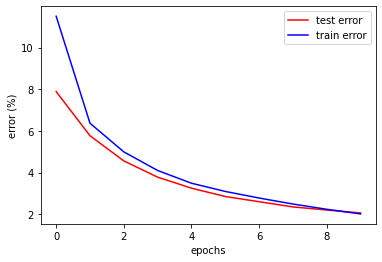

<Figure size 432x288 with 0 Axes>

In [23]:
"""we can then plot the error per epoch on the training and test data"""

plt.xlabel("epochs")
plt.ylabel("error (%)")
plt.plot(np.arange(len(test_err_log)), test_err_log, color='red')
plt.plot(np.arange(len(train_err_log)), train_err_log, color='blue')
plt.legend(['test error', 'train error'], loc='upper right')
plt.show()
plt.clf()

In [24]:
"""next, you have to implement a ReLU activation function ReLU(x) = max(0,x).
implement the forward and backward methods of the following class. use the
provided EDF source code to understand what each method should do. note that
since ReLU has no parameters, it might be helpful to base your implementation
on how the Sigmoid EDF CompNode is implemented."""

class ReLU(edf.CompNode):
    def __init__(self, x):
        edf.CompNodes.append(self)
        self.x = x

    def forward(self):

        bounded = np.maximum(-10,np.minimum(10,self.x.value)) #blocks numerical warnings
        self.value = np.maximum(0, self.x.value)

    def backward(self):

        f = np.greater(self.value,0).astype(int)
        self.x.addgrad(self.grad*f)

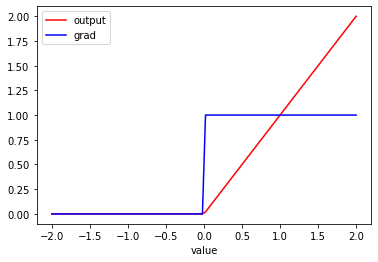

<Figure size 432x288 with 0 Axes>

In [25]:
"""the code below will plot the output and gradients computed by your
implementation of the ReLU component above. check if the plots match
ReLU(x) and dReLU/dx(x) as a sanity test of your implementation."""

values = np.linspace(-2,2,100)
edf.clear_compgraph()
param = edf.Parameter(values[None, :])
output = ReLU(param)

edf.Forward()
edf.Backward(output)

plt.xlabel("value")
plt.plot(values, output.value[0], color='red')
plt.plot(values, param.grad[0], color='blue')
plt.legend(['output', 'grad'], loc='upper left')
plt.show()
plt.clf()

In [26]:
"""now, train the same network as before but with a ReLU activation
in the hidden layer instead of a Sigmoid."""

def MLPrelugraph(Phi, x):
    h = ReLU(edf.Affine(Phi.first, x))
    return edf.Softmax(edf.Affine(Phi.last, h))

np.random.seed(1234)
edf.clear_compgraph()
xnode = edf.Input()
ynode = edf.Input()
nHiddens = 64
Phi = MLPparams(nInputs, nHiddens, nLabels)
probnode = MLPrelugraph(Phi, xnode)
lossnode = edf.LogLoss(probnode, ynode)

In [27]:
num_epochs = 10
batch_size = 64
edf.learning_rate = 0.5
train_err_log, test_err_log = train(num_epochs, batch_size, xnode, ynode, probnode, lossnode)

Epoch: 1/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 7.99 %
	 Test Error 6.50 %
Epoch: 2/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 3.70 %
	 Test Error 4.08 %
Epoch: 3/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 2.72 %
	 Test Error 2.79 %
Epoch: 4/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 2.16 %
	 Test Error 2.49 %
Epoch: 5/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 1.79 %
	 Test Error 2.12 %
Epoch: 6/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 1.50 %
	 Test Error 2.00 %
Epoch: 7/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 1.36 %
	 Test Error 2.20 %
Epoch: 8/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 1.10 %
	 Test Error 1.88 %
Epoch: 9/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 0.99 %
	 Test Error 1.57 %
Epoch: 10/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 0.85 %
	 Test Error 1.31 %


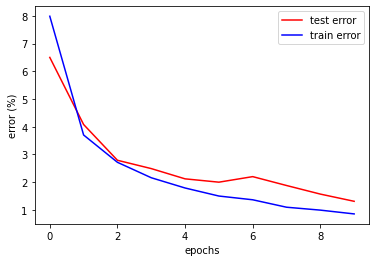

<Figure size 432x288 with 0 Axes>

In [28]:
plt.xlabel("epochs")
plt.ylabel("error (%)")
plt.plot(np.arange(len(test_err_log)), test_err_log, color='red')
plt.plot(np.arange(len(train_err_log)), train_err_log, color='blue')
plt.legend(['test error', 'train error'], loc='upper right')
plt.show()
plt.clf()

In [29]:
"""now, implement the Tanh activation function by filling the missing
code in the forward and backward methods below. it might be helpful to derive
a relationship between Tanh and Sigmoid so that you can re-use parts of 
EDF's Sigmoid code."""

class Tanh(edf.CompNode):
    def __init__(self, x):
        edf.CompNodes.append(self)
        self.x = x

    def forward(self):
        self.value = (np.exp(2*self.x.value)-1)/(np.exp(2*self.x.value)+1)

    def backward(self):
        self.x.addgrad(self.grad*(1-self.value*self.value))

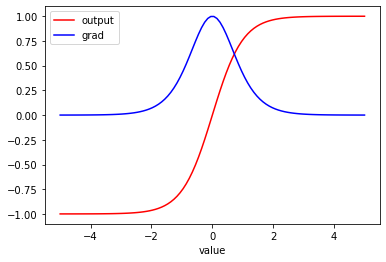

<Figure size 432x288 with 0 Axes>

In [30]:
"""again, make sure that the output and gradients plotted below are correct."""

values = np.linspace(-5,5,100)
edf.clear_compgraph()
param = edf.Parameter(values[None, :])
output = Tanh(param)

edf.Forward()
edf.Backward(output)

plt.xlabel("value")
plt.plot(values, output.value[0], color='red')
plt.plot(values, param.grad[0], color='blue')
plt.legend(['output', 'grad'], loc='upper left')
plt.show()
plt.clf()

In [31]:
"""you can then train a network with a Tanh activation function instead
of Sigmoid/ReLU."""

def MLPtanhgraph(Phi, x):
    h = Tanh(edf.Affine(Phi.first, x))
    return edf.Softmax(edf.Affine(Phi.last, h))

np.random.seed(1234)
edf.clear_compgraph()
xnode = edf.Input()
ynode = edf.Input()
nHiddens = 64
Phi = MLPparams(nInputs, nHiddens, nLabels)
probnode = MLPtanhgraph(Phi, xnode)
lossnode = edf.LogLoss(probnode, ynode)

In [32]:
num_epochs = 10
batch_size = 64
edf.learning_rate = 0.5
train_err_log, test_err_log = train(num_epochs, batch_size, xnode, ynode, probnode, lossnode)

Epoch: 1/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 8.29 %
	 Test Error 6.01 %
Epoch: 2/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 4.21 %
	 Test Error 4.13 %
Epoch: 3/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 3.05 %
	 Test Error 2.93 %
Epoch: 4/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 2.38 %
	 Test Error 2.26 %
Epoch: 5/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 1.95 %
	 Test Error 1.82 %
Epoch: 6/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 1.60 %
	 Test Error 1.60 %
Epoch: 7/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 1.31 %
	 Test Error 1.41 %
Epoch: 8/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 1.07 %
	 Test Error 1.28 %
Epoch: 9/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 0.84 %
	 Test Error 1.20 %
Epoch: 10/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 0.66 %
	 Test Error 1.21 %


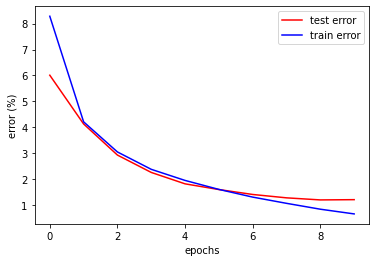

<Figure size 432x288 with 0 Axes>

In [33]:
plt.xlabel("epochs")
plt.ylabel("error (%)")
plt.plot(np.arange(len(test_err_log)), test_err_log, color='red')
plt.plot(np.arange(len(train_err_log)), train_err_log, color='blue')
plt.legend(['test error', 'train error'], loc='upper right')
plt.show()
plt.clf()

In [34]:
"""next, let's check how changing the learning rate affects
the model's train and test error. you should implement a way
to collect the network's final train/test errors for each of
the learning rates in the array below. you should do this for
MLPs with sigmoid and relu activations, and select the best
learning rate for each of the two networks (w/ sigmoid 
and w/ relu activations)"""

"""add code below to train MLPs with sigmoid activations.
your code should populate the arrays train_err_per_lr and
test_err_per_lr, such that they contain the train and test
errors of models trained with each learning rate in the
learning_rates arrays, i.e. train_err_per_lr[1] should contain
the final train error of a sigmoid MLP trained with a learning
rate of 1.0"""

num_epochs = 5
batch_size = 64
learning_rates = [5.0, 1.0, 0.5, 0.1]

sig_train_err_per_lr = []
sig_test_err_per_lr = []

for lr in learning_rates:
    
    np.random.seed(1234)
    edf.clear_compgraph()
    xnode = edf.Input()
    ynode = edf.Input()
    nHiddens = 64
    Phi = MLPparams(nInputs, nHiddens, nLabels)
    probnode = MLPsigmoidgraph(Phi, xnode)
    lossnode = edf.LogLoss(probnode, ynode)

    num_epochs = 10
    batch_size = 64
    edf.learning_rate = lr
    train_err_log, test_err_log = \
    train(num_epochs, batch_size, xnode, ynode, probnode, lossnode)
    
    sig_train_err_per_lr.append(train_err_log)
    sig_test_err_per_lr.append(test_err_log)
    

Epoch: 1/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 11.90 %
	 Test Error 7.51 %
Epoch: 2/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 5.98 %
	 Test Error 6.27 %
Epoch: 3/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 5.00 %
	 Test Error 5.59 %
Epoch: 4/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 4.41 %
	 Test Error 4.72 %
Epoch: 5/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 3.87 %
	 Test Error 4.53 %
Epoch: 6/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 3.67 %
	 Test Error 4.04 %
Epoch: 7/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 3.23 %
	 Test Error 3.97 %
Epoch: 8/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 3.15 %
	 Test Error 3.81 %
Epoch: 9/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 3.03 %
	 Test Error 3.19 %
Epoch: 10/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 2.85 %
	 Test Error 3.26 %
Epoch: 1/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 10.08 %
	 Test Error 6.81 %
Epoch: 2/10
	 Batch 400/937
	

In [35]:
sig_train_err_per_lr = np.array(sig_train_err_per_lr)
sig_test_err_per_lr = np.array(sig_test_err_per_lr)
best_sigmoid_lr = learning_rates[np.argmin(sig_test_err_per_lr[:,-1])]
print('Optimum sigmoid lr: %s' % str(best_sigmoid_lr))

Optimum sigmoid lr: 1.0


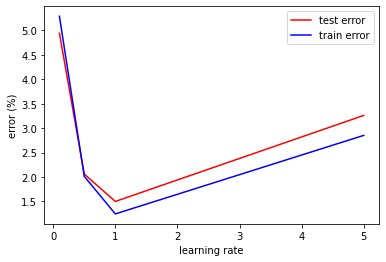

<Figure size 432x288 with 0 Axes>

In [36]:
plt.xlabel("learning rate")
plt.ylabel("error (%)")
plt.plot(learning_rates, sig_test_err_per_lr[:,-1], color='red')
plt.plot(learning_rates, sig_train_err_per_lr[:,-1], color='blue')
plt.legend(['test error', 'train error'], loc='upper right')
plt.show()
plt.clf()

In [37]:
"""now, repeat the experiment above but with a MLP with
a ReLU activation functions in the hidden layer"""

relu_train_err_per_lr = []
relu_test_err_per_lr = []

for lr in learning_rates:
    
    np.random.seed(1234)
    edf.clear_compgraph()
    xnode = edf.Input()
    ynode = edf.Input()
    nHiddens = 64
    Phi = MLPparams(nInputs, nHiddens, nLabels)
    probnode = MLPrelugraph(Phi, xnode)
    lossnode = edf.LogLoss(probnode, ynode)

    num_epochs = 10
    batch_size = 64
    edf.learning_rate = lr
    train_err_log, test_err_log = \
    train(num_epochs, batch_size, xnode, ynode, probnode, lossnode)
    
    relu_train_err_per_lr.append(train_err_log)
    relu_test_err_per_lr.append(test_err_log)

Epoch: 1/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 90.10 %
	 Test Error 90.20 %
Epoch: 2/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 90.27 %
	 Test Error 90.20 %
Epoch: 3/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 90.27 %
	 Test Error 90.20 %
Epoch: 4/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 90.27 %
	 Test Error 90.20 %
Epoch: 5/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 90.27 %
	 Test Error 90.20 %
Epoch: 6/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 90.27 %
	 Test Error 90.20 %
Epoch: 7/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 90.27 %
	 Test Error 90.20 %
Epoch: 8/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 90.27 %
	 Test Error 90.20 %
Epoch: 9/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 90.27 %
	 Test Error 90.20 %
Epoch: 10/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 90.27 %
	 Test Error 90.20 %
Epoch: 1/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 29.75 %
	 Test Error 23.81 %
Epoch: 2/

In [38]:
relu_train_err_per_lr = np.array(relu_train_err_per_lr)
relu_test_err_per_lr = np.array(relu_test_err_per_lr)
best_relu_lr = learning_rates[np.argmin(relu_test_err_per_lr[:,-1])]
print('Optimum relu lr: %s' % str(best_relu_lr))

Optimum relu lr: 0.5


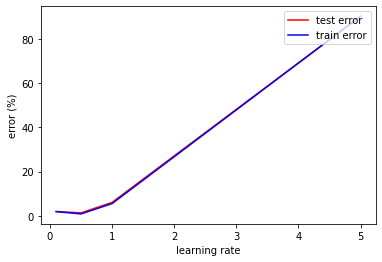

<Figure size 432x288 with 0 Axes>

In [39]:
plt.xlabel("learning rate")
plt.ylabel("error (%)")
plt.plot(learning_rates, relu_test_err_per_lr[:,-1], color='red')
plt.plot(learning_rates, relu_train_err_per_lr[:,-1], color='blue')
plt.legend(['test error', 'train error'], loc='upper right')
plt.show()
plt.clf()

In [40]:
"""finally, we will check how the number of hidden layers affects
the model's performance. start by re-implementing MLPparams such that
it supports multiple layers (note the new nLayers argument). each of the
nLayers-1 hidden layers should have nHiddens neurons."""

class MLPparams(list):
    def __init__(self,nInputs, nHiddens, nLabels, nLayers):

        self.append(edf.AffineParams(nInputs,nHiddens))
        for i in range(nLayers-2): self.append(edf.AffineParams(nHiddens,nHiddens))
        self.append(edf.AffineParams(nHiddens,nLabels))
        self = self.reverse()

        
"""you should also re-implement MLPrelugraph and MLPsigmoidgraph
so that they both have support for multiple layers, following your
re-implementation of MLPparams above."""

def MLPsigmoidgraph(Phi, x, max_len):

    if len(Phi) == 0:
        return x

    if len(Phi) < max_len and len(Phi) > 0:
        return edf.Sigmoid(edf.Affine(Phi[0],MLPsigmoidgraph(Phi[1:],x,max_len)))

    else:
        return edf.Softmax(edf.Affine(Phi[0],MLPsigmoidgraph(Phi[1:],x,max_len)))

def MLPrelugraph(Phi, x, max_len):

    if len(Phi) == 0:
        return x

    if len(Phi) < max_len and len(Phi) > 0:
        return ReLU(edf.Affine(Phi[0],MLPrelugraph(Phi[1:],x,max_len)))

    else:
        return edf.Softmax(edf.Affine(Phi[0],MLPrelugraph(Phi[1:],x,max_len)))



In [41]:
"""similarly to the exploration with different learning rates,
you will see how the depth of the network affects its performance,
first for a sigmoid network. fill the missing code to populate
train_err_per_depth and test_err_per_depth accordingly"""

edf.learning_rate = best_sigmoid_lr
num_epochs = 5
batch_size = 64
num_layers = [2, 4, 6]

sig_train_err_per_depth = []
sig_test_err_per_depth = []

#Clear and initiate
np.random.seed(1234)
edf.clear_compgraph()
xnode = edf.Input()
ynode = edf.Input()

#Loop over list of nLayers
for i, n in enumerate(num_layers):
    print('Training sigmoid net @ depth=%s' % str(n))

    Phi = MLPparams(nInputs, nHiddens, nLabels, n)
    probnode = MLPsigmoidgraph(Phi, xnode, len(Phi))
    lossnode = edf.LogLoss(probnode, ynode)

    train_err_log, test_err_log = \
    train(num_epochs, batch_size, xnode, ynode, probnode, lossnode)

    sig_train_err_per_depth.append(train_err_log)
    sig_test_err_per_depth.append(test_err_log)

Training sigmoid net @ depth=2
Epoch: 1/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 10.08 %
	 Test Error 6.81 %
Epoch: 2/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 4.96 %
	 Test Error 4.68 %
Epoch: 3/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 3.71 %
	 Test Error 3.51 %
Epoch: 4/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 2.98 %
	 Test Error 2.86 %
Epoch: 5/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 2.51 %
	 Test Error 2.39 %
Training sigmoid net @ depth=4
Epoch: 1/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 31.01 %
	 Test Error 10.72 %
Epoch: 2/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 6.33 %
	 Test Error 6.49 %
Epoch: 3/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 4.23 %
	 Test Error 4.50 %
Epoch: 4/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 3.29 %
	 Test Error 3.35 %
Epoch: 5/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 2.63 %
	 Test Error 3.18 %
Training sigmoid net @ depth=6
Epoch: 1/5
	 Batch 400/937
	 Batch

In [42]:
sig_train_err_per_depth = np.array(sig_train_err_per_depth)
sig_test_err_per_depth = np.array(sig_test_err_per_depth)

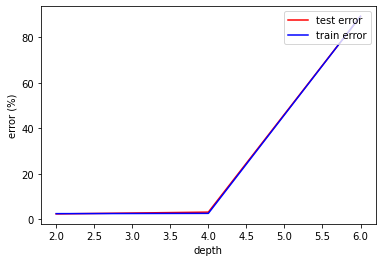

<Figure size 432x288 with 0 Axes>

In [43]:
plt.xlabel("depth")
plt.ylabel("error (%)")
plt.plot(num_layers, sig_test_err_per_depth[:,-1], color='red')
plt.plot(num_layers, sig_train_err_per_depth[:,-1], color='blue')
plt.legend(['test error', 'train error'], loc='upper right')
plt.show()
plt.clf()

In [44]:
"""repeat the above experiment but for a ReLU MLP"""

edf.learning_rate = best_relu_lr
num_epochs = 5
batch_size = 64
num_layers = [3, 5, 10]

relu_train_err_per_depth = []
relu_test_err_per_depth = []

#Clear and initiate
np.random.seed(1234)
edf.clear_compgraph()
xnode = edf.Input()
ynode = edf.Input()

#Loop over list of nLayers
for i, n in enumerate(num_layers):
    print('Training relu net @ depth=%s' % str(n))

    Phi = MLPparams(nInputs, nHiddens, nLabels, n)
    probnode = MLPrelugraph(Phi, xnode, len(Phi))
    lossnode = edf.LogLoss(probnode, ynode)

    train_err_log, test_err_log = \
    train(num_epochs, batch_size, xnode, ynode, probnode, lossnode)

    relu_train_err_per_depth.append(train_err_log)
    relu_test_err_per_depth.append(test_err_log)

Training relu net @ depth=3
Epoch: 1/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 9.98 %
	 Test Error 7.85 %
Epoch: 2/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 4.30 %
	 Test Error 4.85 %
Epoch: 3/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 3.30 %
	 Test Error 3.61 %
Epoch: 4/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 2.65 %
	 Test Error 3.08 %
Epoch: 5/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 2.33 %
	 Test Error 2.59 %
Training relu net @ depth=5
Epoch: 1/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 16.02 %
	 Test Error 13.30 %
Epoch: 2/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 4.93 %
	 Test Error 8.30 %
Epoch: 3/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 3.80 %
	 Test Error 3.58 %
Epoch: 4/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 3.21 %
	 Test Error 3.65 %
Epoch: 5/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 2.73 %
	 Test Error 2.53 %
Training relu net @ depth=10
Epoch: 1/5
	 Batch 400/937
	 Batch 800/937


In [45]:
relu_train_err_per_depth = np.array(relu_train_err_per_depth)
relu_test_err_per_depth = np.array(relu_test_err_per_depth)

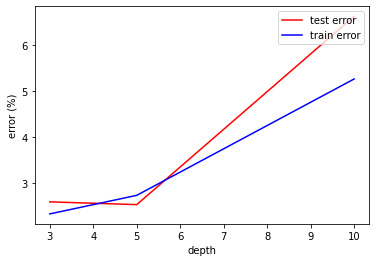

<Figure size 432x288 with 0 Axes>

In [46]:
plt.xlabel("depth")
plt.ylabel("error (%)")
plt.plot(num_layers, relu_test_err_per_depth[:,-1], color='red')
plt.plot(num_layers, relu_train_err_per_depth[:,-1], color='blue')
plt.legend(['test error', 'train error'], loc='upper right')
plt.show()
plt.clf()